In [ ]:
# [C01] Imports y configuración
from TradingviewData import TradingViewData, Interval
from IPython.display import display  # por si el entorno no lo trae por defecto
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

request = TradingViewData()
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)

In [2]:
# [C02] Búsqueda rápida del símbolo (opcional)
request.search("SOLUSD", "BINANCE")

Expecting value: line 1 column 1 (char 0)


[]

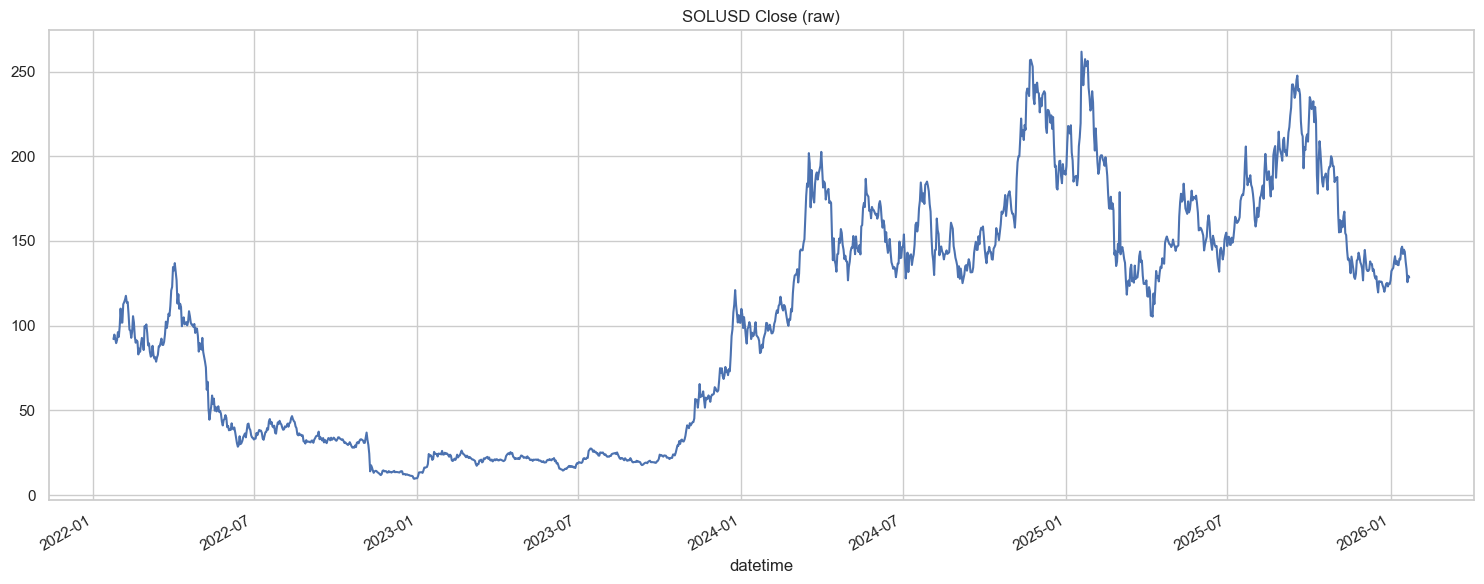

In [3]:
# [C03] Extracción de datos (HU-1: ~4 años, 1D)
solana_data = request.get_hist(
    symbol="SOLUSD",
    exchange="BINANCE",
    interval=Interval.daily,
    n_bars=4 * 365
)

# vistazo rápido
solana_data["close"].plot(figsize=(15, 6), title="SOLUSD Close (raw)")
plt.tight_layout()
plt.show()

In [4]:
# [C04] Normalización temporal y construcción de df diario (1 fila por día, sin 01:00:00)
df_raw = solana_data.copy()

# Asegurar datetime en índice
if "datetime" in df_raw.columns:
    df_raw["datetime"] = pd.to_datetime(df_raw["datetime"], errors="coerce")
    df_raw = df_raw.set_index("datetime")
else:
    df_raw.index = pd.to_datetime(df_raw.index, errors="coerce")

# limpiar datetimes inválidos y ordenar
df_raw = df_raw.loc[~df_raw.index.isna()].sort_index()

# quitar timezone si existiera
if getattr(df_raw.index, "tz", None) is not None:
    df_raw.index = df_raw.index.tz_localize(None)

print("Rango temporal (df_raw):")
print("Min:", df_raw.index.min())
print("Max:", df_raw.index.max())
print("N filas:", len(df_raw))

# Crear df_daily: normalizar a fecha y consolidar por día
df_daily = df_raw.copy()
df_daily["date"] = df_daily.index.normalize()

agg = {
    "symbol": "last",
    "open": "first",
    "high": "max",
    "low": "min",
    "close": "last",
    "volume": "sum",
}
df_daily = df_daily.groupby("date", as_index=True).agg(agg)
df_daily.index.name = "datetime"

print("\nShapes -> df_raw:", df_raw.shape, "| df_daily:", df_daily.shape)
print("Ejemplo índice df_daily:", df_daily.index[:3])
display(df_daily.head())

# A partir de aquí, df será el dataset "canónico" para el EDA (1 fila por día)
df = df_daily.copy()

Rango temporal (df_raw):
Min: 2022-01-24 01:00:00
Max: 2026-01-22 01:00:00
N filas: 1460

Shapes -> df_raw: (1460, 6) | df_daily: (1460, 6)
Ejemplo índice df_daily: DatetimeIndex(['2022-01-24', '2022-01-25', '2022-01-26'], dtype='datetime64[us]', name='datetime', freq=None)


,symbol,open,high,low,close,volume
datetime,,,,,,
2022-01-24,BINANCE:SOLUSD,99.85,100.00,81.03,92.08,828294.89
2022-01-25,BINANCE:SOLUSD,91.86,100.02,87.57,94.75,343713.58
2022-01-26,BINANCE:SOLUSD,94.71,104.39,89.44,92.19,387754.82
2022-01-27,BINANCE:SOLUSD,92.16,94.74,85.69,89.69,322880.31
2022-01-28,BINANCE:SOLUSD,89.65,93.54,87.19,91.46,224357.75


In [5]:
# [C05] Vista inicial del dataset (shape, index, columns, head)
print("Shape:", df.shape)
print("Index name:", df.index.name)
print("Columns:", list(df.columns))
display(df.head())

Shape: (1460, 6)
Index name: datetime
Columns: ['symbol', 'open', 'high', 'low', 'close', 'volume']


,symbol,open,high,low,close,volume
datetime,,,,,,
2022-01-24,BINANCE:SOLUSD,99.85,100.00,81.03,92.08,828294.89
2022-01-25,BINANCE:SOLUSD,91.86,100.02,87.57,94.75,343713.58
2022-01-26,BINANCE:SOLUSD,94.71,104.39,89.44,92.19,387754.82
2022-01-27,BINANCE:SOLUSD,92.16,94.74,85.69,89.69,322880.31
2022-01-28,BINANCE:SOLUSD,89.65,93.54,87.19,91.46,224357.75


In [19]:
# [C06] Columnas esperadas y chequeos rápidos
expected_cols = {"symbol", "open", "high", "low", "close", "volume"}
missing_cols = expected_cols - set(df.columns)
extra_cols = set(df.columns) - expected_cols

if missing_cols:
    print("[WARN] Faltan columnas esperadas:", missing_cols)
if extra_cols:
    print("[WARN] Columnas adicionales detectadas:", extra_cols)
else:
    print("[INFO] La estructura de los datos es correcta.")

[INFO] La estructura de los datos es correcta.


In [7]:
# [C07] Tipos numéricos y nulos
for c in ["open", "high", "low", "close", "volume"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

print("Info:")
display(df.info())

print("\nNulos por columna:")
display(df.isna().sum().to_frame("n_nulls"))

null_rows = df[df[["open", "high", "low", "close", "volume"]].isna().any(axis=1)]
print("\nFilas con algún nulo en OHLCV:", len(null_rows))
if len(null_rows) > 0:
    display(null_rows.head(10))

Info:
<class 'pandas.DataFrame'>
DatetimeIndex: 1460 entries, 2022-01-24 to 2026-01-22
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   symbol  1460 non-null   str    
 1   open    1460 non-null   float64
 2   high    1460 non-null   float64
 3   low     1460 non-null   float64
 4   close   1460 non-null   float64
 5   volume  1460 non-null   float64
dtypes: float64(5), str(1)
memory usage: 79.8 KB


None


Nulos por columna:


,n_nulls
symbol,0
open,0
high,0
low,0
close,0
volume,0



Filas con algún nulo en OHLCV: 0


In [8]:
# [C08] Integridad: símbolo, duplicados y coherencia OHLC
if "symbol" in df.columns:
    print("Símbolos únicos:", df["symbol"].nunique())
    display(df["symbol"].value_counts().head(10))

dup_idx = df.index.duplicated(keep=False)
print("\nDuplicados por datetime:", int(dup_idx.sum()))
if dup_idx.sum() > 0:
    display(df.loc[dup_idx].head(10))

checks = {
    "high_ge_open_close": (df["high"] >= df[["open", "close"]].max(axis=1)),
    "low_le_open_close":  (df["low"]  <= df[["open", "close"]].min(axis=1)),
    "high_ge_low":        (df["high"] >= df["low"]),
    "prices_positive":    (df[["open", "high", "low", "close"]] > 0).all(axis=1),
    "volume_nonneg":      (df["volume"] >= 0),
}

violations = {}
for name, mask in checks.items():
    n_bad = int((~mask).sum())
    print(f"{name}: BAD={n_bad}")
    if n_bad > 0:
        violations[name] = df.loc[~mask, ["symbol", "open", "high", "low", "close", "volume"]].head(10)

if violations:
    print("\n[WARN] Ejemplos de violaciones (primeras filas):")
    for k, v in violations.items():
        print(f"\n--- {k} ---")
        display(v)

Símbolos únicos: 1


symbol
BINANCE:SOLUSD    1460
Name: count, dtype: int64


Duplicados por datetime: 0
high_ge_open_close: BAD=0
low_le_open_close: BAD=0
high_ge_low: BAD=0
prices_positive: BAD=0
volume_nonneg: BAD=0


In [9]:
# [C09] Frecuencia diaria y días faltantes (en el span min-max)
full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
missing_days = full_idx.difference(df.index)

print("Total días esperados (min-max, D):", len(full_idx))
print("Días presentes:", df.index.nunique())
print("Días faltantes:", len(missing_days))

if len(missing_days) > 0:
    display(pd.Series(missing_days[:20], name="missing_days"))

Total días esperados (min-max, D): 1460
Días presentes: 1460
Días faltantes: 0


In [10]:
# [C10] Cobertura real ~4 años (span, días únicos, faltantes)
min_dt = df.index.min()
max_dt = df.index.max()

span_days = (max_dt - min_dt).days + 1
unique_days = df.index.nunique()
missing_days_span = span_days - unique_days

min_expected = 4 * 365  # según n_bars usado
coverage_ok = unique_days >= min_expected
missing_ok = missing_days_span == 0

summary_cov = {
    "min_date": min_dt.date(),
    "max_date": max_dt.date(),
    "span_days_calendar": span_days,
    "unique_days_rows": unique_days,
    "missing_days_between_min_max": int(missing_days_span),
    "coverage_unique_days>=1460": bool(coverage_ok),
    "no_missing_days_in_span": bool(missing_ok),
}
display(pd.DataFrame([summary_cov]).T.rename(columns={0: "value"}))

if not coverage_ok:
    print(f"\n[WARN] Cobertura menor de {min_expected} días. Revisa extracción.")
if not missing_ok:
    print("\n[WARN] Hay huecos (días faltantes) dentro del rango min-max.")

,value
min_date,2022-01-24
max_date,2026-01-22
span_days_calendar,1460
unique_days_rows,1460
missing_days_between_min_max,0
coverage_unique_days>=1460,True
no_missing_days_in_span,True


In [11]:
# [C11] Cobertura de fines de semana (cripto debería tener 7/7)
full_days = pd.date_range(df.index.min(), df.index.max(), freq="D")
present_days = pd.Index(df.index)

weekday = pd.Series(full_days.weekday, index=full_days)  # Mon=0 ... Sun=6
is_weekend = weekday.isin([5, 6])  # Sat, Sun

expected_weekend_days = full_days[is_weekend.values]
present_weekend_days = expected_weekend_days.intersection(present_days)
missing_weekend_days = expected_weekend_days.difference(present_days)

summary_weekend = {
    "expected_weekend_days_in_span": int(len(expected_weekend_days)),
    "present_weekend_days": int(len(present_weekend_days)),
    "missing_weekend_days": int(len(missing_weekend_days)),
    "weekend_coverage_ratio": float(len(present_weekend_days) / len(expected_weekend_days)) if len(expected_weekend_days) else np.nan,
}
display(pd.DataFrame([summary_weekend]).T.rename(columns={0: "value"}))

if len(missing_weekend_days) > 0:
    print("\n[WARN] Ejemplos de fines de semana faltantes (primeros 20):")
    display(pd.Series(missing_weekend_days[:20], name="missing_weekend_days"))

,value
expected_weekend_days_in_span,416.0
present_weekend_days,416.0
missing_weekend_days,0.0
weekend_coverage_ratio,1.0


In [ ]:
# [C12] Cobertura mensual (días por mes y meses faltantes)
import calendar

tmp = df.copy()
tmp = tmp.sort_index()

data_min = tmp.index.min().normalize()
data_max = tmp.index.max().normalize()

tmp["year"] = tmp.index.year
tmp["month"] = tmp.index.month

# días presentes por mes
days_per_month = (
    tmp.groupby(["year", "month"])
       .size()
       .rename("days_present")
       .reset_index()
)

def month_bounds(year: int, month: int):
    last_day = calendar.monthrange(year, month)[1]
    m_start = pd.Timestamp(year=year, month=month, day=1)
    m_end   = pd.Timestamp(year=year, month=month, day=last_day)
    return m_start, m_end

# calcular expected_days "reales" (recortando por data_min/data_max)
expected_starts = []
expected_ends = []
expected_days = []
is_partial = []

for y, m in zip(days_per_month["year"], days_per_month["month"]):
    m_start, m_end = month_bounds(int(y), int(m))
    e_start = max(m_start, data_min)
    e_end   = min(m_end, data_max)

    expected_starts.append(e_start)
    expected_ends.append(e_end)

    # si el mes queda fuera del rango (no debería), protegemos:
    if e_end < e_start:
        exp = 0
    else:
        exp = (e_end - e_start).days + 1

    expected_days.append(exp)
    is_partial.append((e_start != m_start) or (e_end != m_end))

days_per_month["expected_start"] = expected_starts
days_per_month["expected_end"] = expected_ends
days_per_month["days_expected_real"] = expected_days
days_per_month["is_partial_month"] = is_partial

days_per_month["missing_days_real"] = days_per_month["days_expected_real"] - days_per_month["days_present"]

# por si hubiera duplicados raros (missing negativo), lo capamos y avisamos
neg = (days_per_month["missing_days_real"] < 0).sum()
if neg > 0:
    print(f"[WARN] {neg} meses con missing negativo (posibles duplicados por día). Se recorta a 0.")
    days_per_month["missing_days_real"] = days_per_month["missing_days_real"].clip(lower=0)

print("Resumen días por mes (muestra):")
display(
    days_per_month.sort_values(["year", "month"])
                 .head(24)
)

print("\nMeses parciales (normalmente solo primero/último):")
display(days_per_month[days_per_month["is_partial_month"]].sort_values(["year", "month"]))

# meses presentes por año
months_per_year = days_per_month.groupby("year")["month"].nunique().rename("months_present")
print("\nMeses presentes por año:")
display(months_per_year.to_frame())

# meses completos faltantes entre min y max (sin PeriodIndex)
start = data_min
end = data_max

months_all = []
y, m = start.year, start.month
while (y < end.year) or (y == end.year and m <= end.month):
    months_all.append((y, m))
    m += 1
    if m == 13:
        m = 1
        y += 1

present = set(zip(days_per_month["year"], days_per_month["month"]))
missing_months = [f"{yy}-{mm:02d}" for (yy, mm) in months_all if (yy, mm) not in present]

print("\nMeses completos faltantes:", len(missing_months))
if missing_months:
    display(pd.Series(missing_months[:24], name="missing_months"))

Resumen días por mes (muestra):


,year,month,days_present,expected_start,expected_end,days_expected_real,is_partial_month,missing_days_real
0,2022,1,8,2022-01-24,2022-01-31,8,True,0
1,2022,2,28,2022-02-01,2022-02-28,28,False,0
2,2022,3,31,2022-03-01,2022-03-31,31,False,0
3,2022,4,30,2022-04-01,2022-04-30,30,False,0
4,2022,5,31,2022-05-01,2022-05-31,31,False,0
5,2022,6,30,2022-06-01,2022-06-30,30,False,0
6,2022,7,31,2022-07-01,2022-07-31,31,False,0
7,2022,8,31,2022-08-01,2022-08-31,31,False,0
8,2022,9,30,2022-09-01,2022-09-30,30,False,0
9,2022,10,31,2022-10-01,2022-10-31,31,False,0



Meses parciales (normalmente solo primero/último):


,year,month,days_present,expected_start,expected_end,days_expected_real,is_partial_month,missing_days_real
0,2022,1,8,2022-01-24,2022-01-31,8,True,0
48,2026,1,22,2026-01-01,2026-01-22,22,True,0



Meses presentes por año:


,months_present
year,
2022,12
2023,12
2024,12
2025,12
2026,1



Meses completos faltantes: 0


In [13]:
# [C13] Estadísticos básicos y sanity checks de máximos
display(df[["open", "high", "low", "close", "volume"]].describe(
    percentiles=[.01, .05, .25, .5, .75, .95, .99]
).T)

print("\nTop 5 closes máximos:")
display(df.sort_values("close", ascending=False).head(5)[["symbol", "open", "high", "low", "close", "volume"]])

print("\nTop 5 volumes máximos:")
display(df.sort_values("volume", ascending=False).head(5)[["symbol", "open", "high", "low", "close", "volume"]])

,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max
open,1460.0,103.045870,69.274745,9.630,12.19900,16.37500,30.47750,107.285,155.8300,216.2625,2.423484e+02,261.69
high,1460.0,106.729027,71.515392,10.070,12.47180,17.11250,31.97500,112.305,161.2975,222.1940,2.513118e+02,295.31
low,1460.0,99.335260,66.968883,7.960,11.70360,15.53150,29.38250,102.840,150.6525,206.8845,2.357309e+02,253.11
close,1460.0,103.064890,69.277381,9.640,12.19900,16.37500,30.48000,107.695,155.7975,216.1640,2.423592e+02,261.72
volume,1460.0,326240.901123,323524.319031,23990.956,43588.02213,74551.50495,154191.78325,242044.385,384883.5150,830950.4399,1.607145e+06,4564726.99



Top 5 closes máximos:


,symbol,open,high,low,close,volume
datetime,,,,,,
2025-01-18,BINANCE:SOLUSD,219.72,270.25,217.36,261.72,1649941.498
2025-01-22,BINANCE:SOLUSD,250.31,272.02,248.58,257.31,586356.421
2024-11-22,BINANCE:SOLUSD,256.85,264.32,251.90,256.99,445792.454
2024-11-21,BINANCE:SOLUSD,235.54,259.91,229.80,256.69,548694.748
2025-01-25,BINANCE:SOLUSD,252.99,260.74,246.35,256.30,295298.412



Top 5 volumes máximos:


,symbol,open,high,low,close,volume
datetime,,,,,,
2022-11-10,BINANCE:SOLUSD,14.04,18.79,13.10,17.62,4564726.990
2022-11-09,BINANCE:SOLUSD,24.39,24.60,12.38,14.05,4089214.410
2022-11-08,BINANCE:SOLUSD,29.57,31.65,19.84,24.38,3383506.540
2025-01-19,BINANCE:SOLUSD,261.69,295.31,237.75,252.06,2348545.032
2023-11-01,BINANCE:SOLUSD,38.44,46.65,37.87,41.18,2288779.840


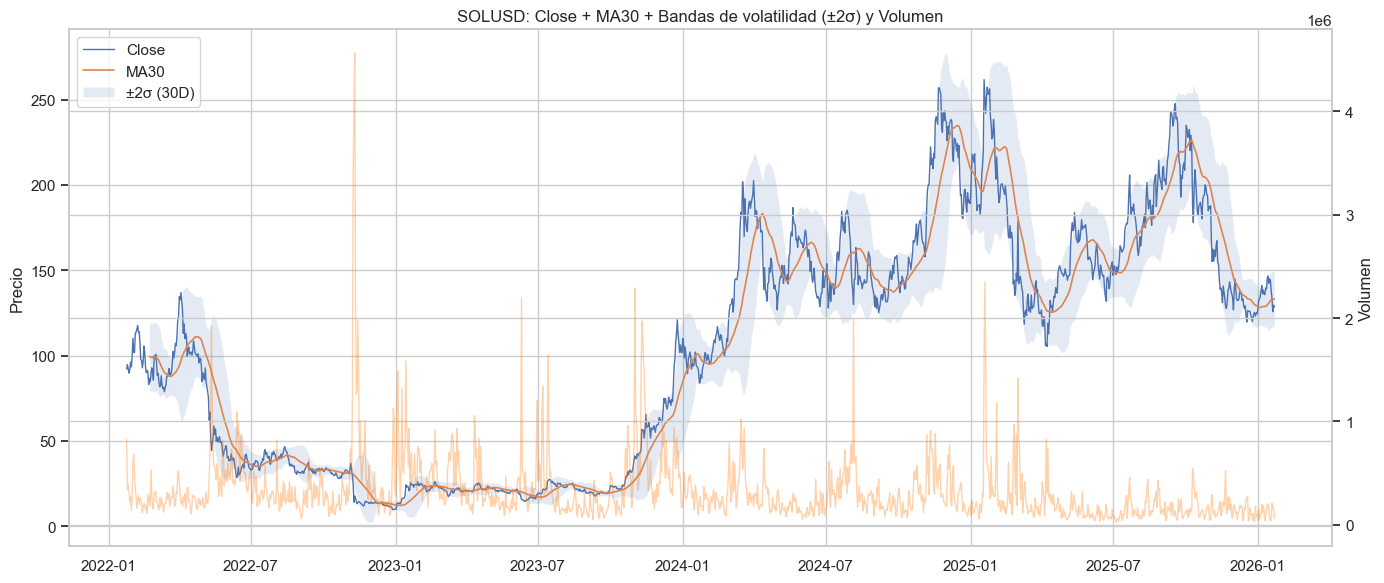

In [14]:
# [P01] Plot: Close + MA30 + bandas ±2σ y volumen (2 ejes)
df_plot = df.copy()

win = 30
df_plot["ma30"] = df_plot["close"].rolling(win).mean()
df_plot["std30"] = df_plot["close"].rolling(win).std()
df_plot["upper"] = df_plot["ma30"] + 2 * df_plot["std30"]
df_plot["lower"] = df_plot["ma30"] - 2 * df_plot["std30"]

fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.plot(df_plot.index, df_plot["close"], label="Close", linewidth=1)
ax1.plot(df_plot.index, df_plot["ma30"], label=f"MA{win}", linewidth=1.2)
ax1.fill_between(df_plot.index, df_plot["upper"], df_plot["lower"], alpha=0.15, label="±2σ (30D)")

ax1.set_title("SOLUSD: Close + MA30 + Bandas de volatilidad (±2σ) y Volumen")
ax1.set_ylabel("Precio")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(df_plot.index, df_plot["volume"], color="tab:orange", alpha=0.35, linewidth=1)
ax2.set_ylabel("Volumen")

plt.tight_layout()
plt.show()

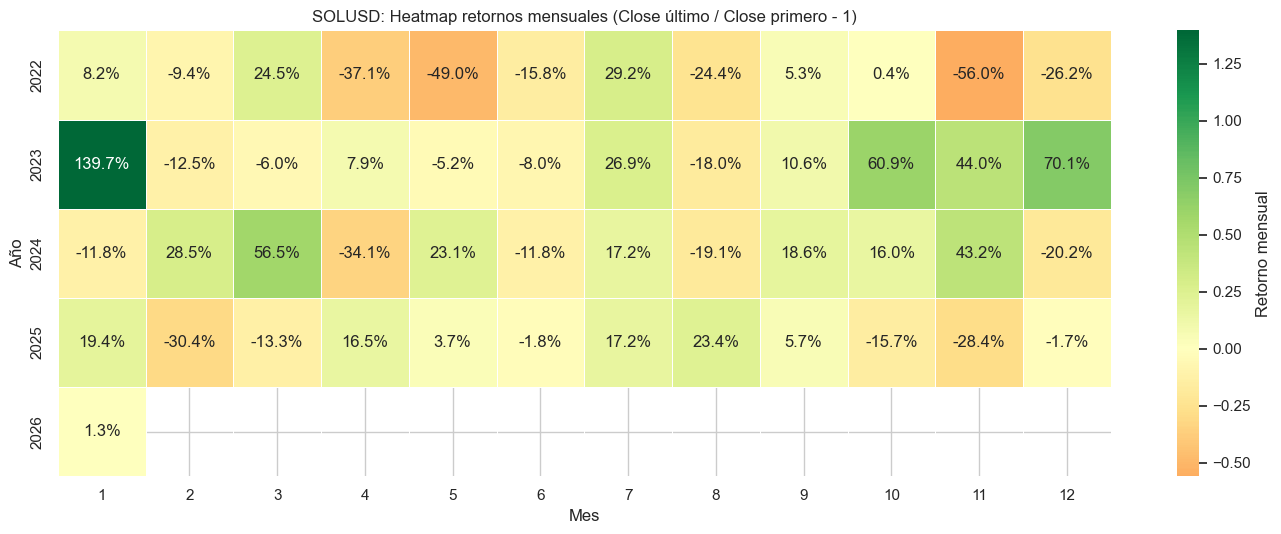

In [15]:
# [P02] Plot: Heatmap de retornos mensuales (Close último / Close primero - 1)
tmp = df.copy()
tmp["year"] = tmp.index.year
tmp["month"] = tmp.index.month

monthly_close = tmp.groupby(["year", "month"])["close"].agg(first="first", last="last")
monthly_close["ret_m"] = (monthly_close["last"] / monthly_close["first"]) - 1

pivot = monthly_close["ret_m"].unstack("month").sort_index()
pivot = pivot.reindex(columns=range(1, 13)).astype(float)

annot = pivot.copy()
for c in annot.columns:
    annot[c] = annot[c].map(lambda x: "" if pd.isna(x) else f"{x*100:.1f}%")

plt.figure(figsize=(14, 4 + 0.3 * len(pivot)))
sns.heatmap(
    pivot,
    annot=annot.values,
    fmt="",
    cmap="RdYlGn",
    center=0,
    linewidths=0.5,
    cbar_kws={"label": "Retorno mensual"}
)
plt.title("SOLUSD: Heatmap retornos mensuales (Close último / Close primero - 1)")
plt.xlabel("Mes")
plt.ylabel("Año")
plt.tight_layout()
plt.show()

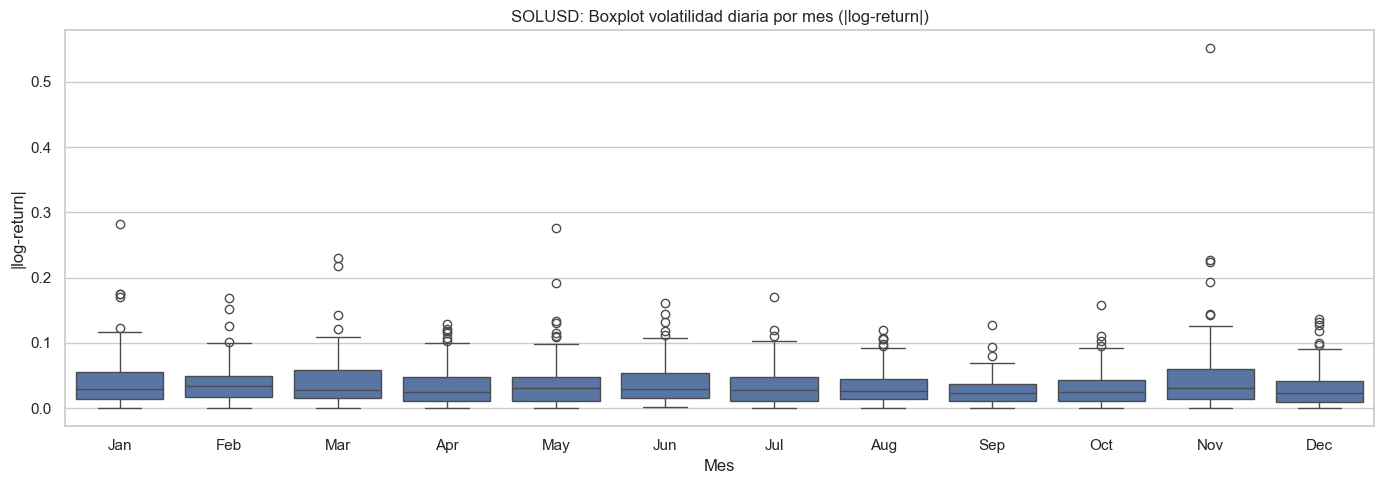

In [16]:
# [P03] Plot: Boxplot de volatilidad diaria por mes (|log-return|)
df_box = df.copy()

# evitar log de precios no positivos (por seguridad)
df_box = df_box[df_box["close"] > 0].copy()

df_box["log_ret"] = np.log(df_box["close"]).diff()
df_box["abs_log_ret"] = df_box["log_ret"].abs()
df_box["month"] = df_box.index.month_name().str[:3]
df_box["month_num"] = df_box.index.month

order = df_box.dropna().sort_values("month_num")["month"].unique()

plt.figure(figsize=(14, 5))
sns.boxplot(
    data=df_box.dropna(subset=["abs_log_ret"]),
    x="month",
    y="abs_log_ret",
    order=order,
    showfliers=True
)
plt.title("SOLUSD: Boxplot volatilidad diaria por mes (|log-return|)")
plt.xlabel("Mes")
plt.ylabel("|log-return|")
plt.tight_layout()
plt.show()

In [17]:
# [C14] Returns y outliers simples (z-score sobre log-returns)
df_ = df.copy()
df_ = df_[df_["close"] > 0].copy()
df_["log_return"] = np.log(df_["close"]).diff()

lr = df_["log_return"].dropna()
z = (lr - lr.mean()) / lr.std(ddof=0)

outlier_idx = z.index[z.abs() > 6]
outliers = df_.loc[outlier_idx, ["symbol", "close", "volume", "log_return"]].sort_values("log_return")

print("Outliers |z|>6 en log_return:", len(outliers))
display(outliers.head(20))

Outliers |z|>6 en log_return: 1


,symbol,close,volume,log_return
datetime,,,,
2022-11-09,BINANCE:SOLUSD,14.05,4089214.41,-0.551141


In [18]:
# [C15] Resumen final de calidad de datos (HU-1)
# recomputar métricas clave aquí para que la celda sea “autónoma”
full_idx = pd.date_range(df.index.min(), df.index.max(), freq="D")
missing_days = full_idx.difference(df.index)

checks2 = {
    "high_ge_open_close": (df["high"] >= df[["open", "close"]].max(axis=1)),
    "low_le_open_close":  (df["low"]  <= df[["open", "close"]].min(axis=1)),
    "high_ge_low":        (df["high"] >= df["low"]),
    "prices_positive":    (df[["open", "high", "low", "close"]] > 0).all(axis=1),
    "volume_nonneg":      (df["volume"] >= 0),
}

summary = {
    "rows": len(df),
    "min_datetime": df.index.min(),
    "max_datetime": df.index.max(),
    "n_unique_days": int(df.index.nunique()),
    "n_missing_days_between_min_max": int(len(missing_days)),
    "n_duplicate_datetimes": int(df.index.duplicated().sum()),
    "n_null_any_ohlcv": int(df[["open", "high", "low", "close", "volume"]].isna().any(axis=1).sum()),
    "n_bad_ohlc_rules_any": int((~checks2["high_ge_open_close"] | ~checks2["low_le_open_close"] | ~checks2["high_ge_low"] | ~checks2["prices_positive"]).sum()),
    "n_negative_volume": int((~checks2["volume_nonneg"]).sum()),
}
display(pd.DataFrame([summary]).T.rename(columns={0: "value"}))

,value
rows,1460
min_datetime,2022-01-24 00:00:00
max_datetime,2026-01-22 00:00:00
n_unique_days,1460
n_missing_days_between_min_max,0
n_duplicate_datetimes,0
n_null_any_ohlcv,0
n_bad_ohlc_rules_any,0
n_negative_volume,0
